In [ ]:
#import librairies
import tensorflow as tf
import pathlib
import pickle
from tensorflow.keras.layers import Conv2D
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
tf.__version__

'2.7.0'

# Nouvelle section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO")
print(train_dataset)

/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO


In [ ]:
for item in train_dataset.iterdir():
  print(item)

/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO/6210741
/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO/6151578
/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO/6172421
/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO/4220631
/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO/300223
/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO/403221


In [ ]:
img_generator = ImageDataGenerator(
    rotation_range=180, # Angle range for random image rotation
    width_shift_range=0.1, # Random shift of the image along width axis
    height_shift_range=0.1, # Random shift of the image along height axis
    brightness_range=(0.5,1), # Random brightness modification
    shear_range=0.1, # Random distortion of the image
    zoom_range=0.1, # Random zoom on the image
    channel_shift_range=50.0, # Random hue modification
    horizontal_flip=True, # Randomly flips image horizontally
    vertical_flip=True, # Randomly flips image virtically
    rescale=1/255., # Rescaling values from [0,255]->[0,1]
    fill_mode='wrap',
    validation_split=0.3 # Portion of the data that can be saved for validation
)

In [ ]:
directory_generator = img_generator.flow_from_directory(
    directory = "/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO", # the folder where the class subfolders can be found
    target_size = (224,224), # The (height,width) of the produced images
    class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
    batch_size=16, # The batch size of the produced batches
    shuffle = True, #Whether to shuffle after all files have been selected once
    subset = "training"
)

directory_generator_val = img_generator.flow_from_directory(
    directory = "/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/PHASE_1 LEGO", # the folder where the class subfolders can be found
    target_size = (224,224), # The (height,width) of the produced images
    class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
    batch_size=16, # The batch size of the produced batches
    shuffle = True, #Whether to shuffle after all files have been selected once
    subset = "validation"
)

Found 173 images belonging to 6 classes.
Found 70 images belonging to 6 classes.


In [ ]:
label_map = (directory_generator.class_indices)
label_map

{'300223': 0,
 '403221': 1,
 '4220631': 2,
 '6151578': 3,
 '6172421': 4,
 '6210741': 5}

In [ ]:
# Importing a pre-trained model
base_model = tf.keras.applications.xception.Xception(input_shape=(224,224,3), 
                                               include_top=False,
                                               weights = "imagenet"
                                               )

In [ ]:
imgs, targets = next(iter(directory_generator))
fig, ax = plt.subplots(8,2, figsize=(10,40))
for i, (img, target) in enumerate(zip(imgs, targets)):
  ax[i-8*(i//8),i//8].imshow(img)
  ax[i-8*(i//8),i//8].title.set_text(str(target))
fig.show()

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
# freeze our model so that only the custom layers will train
base_model.trainable = False

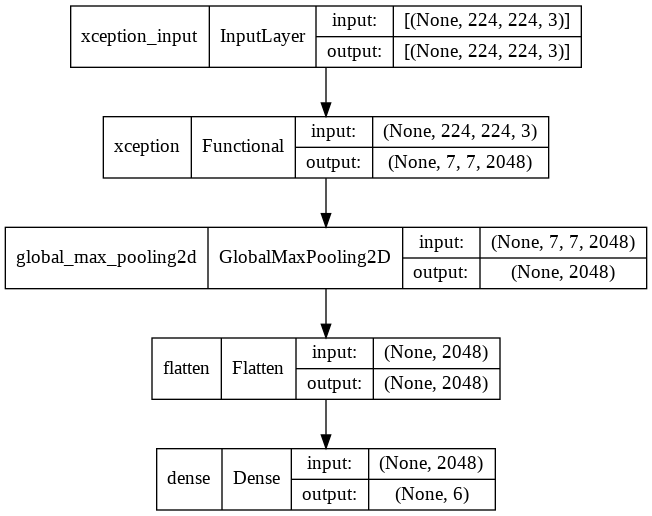

In [ ]:
# Adapting the model to the dataset

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation="softmax")
])

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [ ]:
%%time

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/LEGO/models/training_Xception/cp-{epoch:04d}.ckpt" # the path where checkpoint files
# will be stored

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    save_freq=5*len(directory_generator))

# Train the model with the new callback
history_Xception_224 = model.fit(directory_generator, 
          epochs = 50, 
          validation_data=directory_generator_val,
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

with open('/content/drive/MyDrive/Colab Notebooks/LEGO/models/trainHistoryXception224Dict', 'wb') as file_pi:
    pickle.dump(history_Xception_224.history, file_pi)

# To save the model
model.save("/content/drive/MyDrive/Colab Notebooks/LEGO/models/Xception224_model.h5")

Epoch 1/50
11/11 [==============================] - 157s 14s/step - loss: 1.9153 - sparse_categorical_accuracy: 0.3353 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.6571
Epoch 2/50
11/11 [==============================] - 71s 6s/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7803 - val_loss: 0.7456 - val_sparse_categorical_accuracy: 0.6857
Epoch 3/50
11/11 [==============================] - 71s 6s/step - loss: 0.3762 - sparse_categorical_accuracy: 0.8844 - val_loss: 0.4545 - val_sparse_categorical_accuracy: 0.8429
Epoch 4/50
11/11 [==============================] - 71s 6s/step - loss: 0.2464 - sparse_categorical_accuracy: 0.9249 - val_loss: 0.4928 - val_sparse_categorical_accuracy: 0.7714
Epoch 5/50
10/11 [==========================>...] - ETA: 4s - loss: 0.2206 - sparse_categorical_accuracy: 0.9618
Epoch 00005: saving model to /content/drive/MyDrive/Colab Notebooks/LEGO/models/training_Xception/cp-0005.ckpt
11/11 [==============================] - 73s 7s/step - loss: 0

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


CPU times: user 1h 41min 10s, sys: 2min 39s, total: 1h 43min 49s
Wall time: 1h 6min 16s


In [ ]:
history = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/LEGO/models/Model retenu/trainHistoryXception224Dict', "rb"))
history

{'loss': [1.9153189659118652,
  0.629616379737854,
  0.37616994976997375,
  0.24636735022068024,
  0.21869586408138275,
  0.17989173531532288,
  0.17523327469825745,
  0.1285184919834137,
  0.10731527209281921,
  0.10244029015302658,
  0.151621475815773,
  0.09631375223398209,
  0.09241245687007904,
  0.11398077011108398,
  0.10226406157016754,
  0.07532797008752823,
  0.07030852138996124,
  0.06449972093105316,
  0.07490630447864532,
  0.06135895848274231,
  0.044104475528001785,
  0.044725432991981506,
  0.060437142848968506,
  0.06416983157396317,
  0.03278503566980362,
  0.03314639627933502,
  0.034284479916095734,
  0.041923753917217255,
  0.04726903885602951,
  0.04642639681696892,
  0.05305715650320053,
  0.030248699709773064,
  0.043267808854579926,
  0.037432145327329636,
  0.0744355171918869,
  0.04487873986363411,
  0.038651250302791595,
  0.04314380884170532,
  0.013757091015577316,
  0.026667067781090736,
  0.0315842442214489,
  0.02024046517908573,
  0.029371129348874092,

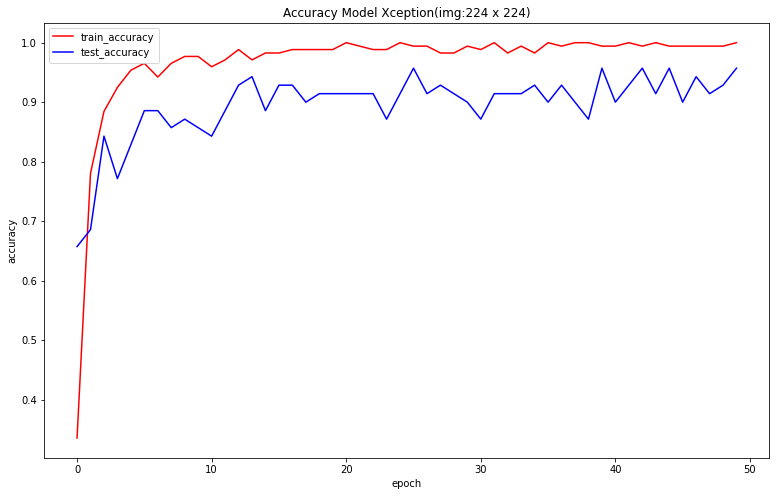

In [ ]:
# Visualise train / Valid Accuracy
plt.figure(figsize=(13,8.0))
plt.plot(history["sparse_categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(history["val_sparse_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Model Xception(img:224 x 224)')
plt.show()

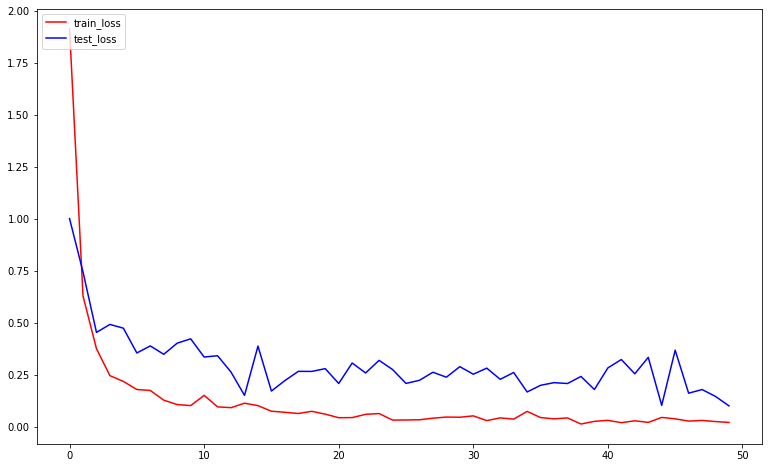

In [ ]:
# Visualise train / Valid Loss
plt.figure(figsize=(13,8.0))
plt.plot(history["loss"], c="r", label="train_loss")
plt.plot(history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#import cv2
#import numpy as np

#img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/Data_Test/11.jpg")
#img
#plt.imshow(img)

In [ ]:
#res = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_NEAREST)
#plt.imshow(res)

In [ ]:
#res.shape

(224, 224, 3)

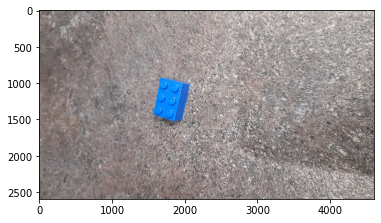

In [ ]:
# Visualize a random picture
img = tf.io.read_file("/content/drive/MyDrive/Colab Notebooks/LEGO/PHOTOS/Data_Test/test_data_seen/300223 (1).jpg")
img = tf.image.decode_jpeg(img, channels=3)
plt.imshow(img)
#print(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


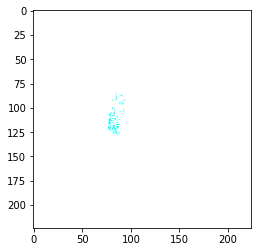

In [ ]:
img = tf.image.resize(img, [224,224])
img.shape
plt.imshow(img)

In [ ]:
# Print what the top predicted class is
preds = model.predict(img[None,:,:,:])

pred_labels = tf.argmax(preds, axis = -1)

print("Prediction output:", preds)

print("Predicted label:", pred_labels)

Prediction output: [[9.2346377e-30 5.0135538e-14 2.1775713e-29 1.0000000e+00 0.0000000e+00
  0.0000000e+00]]
Predicted label: tf.Tensor([3], shape=(1,), dtype=int64)
